#  Predictions
---

## 0. Constants

In [132]:
LOG_DATA_DETAILS_PKL    =  "../artifacts/data_details.pkl"
LOG_MODEL_PATH = "../models/model.pkl"

PREDICTION_DATA_PATH = "../data/raw/prediction.csv"

---
# 1. Imports

In [189]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid", palette="bright")

from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [134]:
with open(LOG_MODEL_PATH, "rb") as f:
    model = pickle.load(f)

In [135]:
model

{'model_description': 'XGBRegressor + Hyperparamter tuning',
 'model_details': 'XGBRegressor(base_score=None, booster=None, callbacks=None,\n             colsample_bylevel=None, colsample_bynode=None,\n             colsample_bytree=None, early_stopping_rounds=None,\n             enable_categorical=False, eval_metric=None, feature_types=None,\n             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n             interaction_constraints=None, learning_rate=0.1, max_bin=None,\n             max_cat_threshold=None, max_cat_to_onehot=None,\n             max_delta_step=None, max_depth=7, max_leaves=None,\n             min_child_weight=None, missing=nan, monotone_constraints=None,\n             n_estimators=1000, n_jobs=None, num_parallel_tree=None,\n             predictor=None, random_state=None, ...)',
 'model_object': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=N

In [136]:
with open(LOG_DATA_DETAILS_PKL, 'rb') as data_file:
    data_details = pickle.load(data_file)

In [137]:
data_details

{'train_data_path': '../data/processed/train.csv',
 'test_data_path': '../data/processed/test.csv',
 'features_names': ['Store',
  'Dept',
  'IsHoliday',
  'Temperature',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment',
  'Type',
  'Size',
  'Month',
  'Year',
  'WeekOfYear'],
 'top_5_features': ['Dept', 'Size', 'Store', 'WeekOfYear', 'Type'],
 'target_name': 'Weekly_Sales'}

In [138]:
prediction_df = pd.read_csv(PREDICTION_DATA_PATH)
prediction_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Type,Size
0,1,2012-11-05,73.77,3.688,8351.4,NaN,10.52,2443.14,3127.88,221.725663,7.143,False,1,A,151315
1,1,2012-11-05,73.77,3.688,8351.4,NaN,10.52,2443.14,3127.88,221.725663,7.143,False,2,A,151315
2,1,2012-11-05,73.77,3.688,8351.4,NaN,10.52,2443.14,3127.88,221.725663,7.143,False,3,A,151315
3,1,2012-11-05,73.77,3.688,8351.4,NaN,10.52,2443.14,3127.88,221.725663,7.143,False,4,A,151315
4,1,2012-11-05,73.77,3.688,8351.4,NaN,10.52,2443.14,3127.88,221.725663,7.143,False,5,A,151315


In [139]:
prediction_df.shape

(126578, 15)

In [201]:
prediction_df.Size.min(), prediction_df.Size.max()

(34875, 219622)

---
## 2. Prediction Data Processing

In [140]:
#Date column processing
X = prediction_df.copy()

X["Date"] = pd.to_datetime(X["Date"])
X["Month"] = X.Date.dt.month
X["Year"] = X.Date.dt.year
X["WeekOfYear"] = X.Date.dt.weekofyear
X = X.drop("Date", axis=1)

C:\Users\MR\AppData\Local\Temp\ipykernel_30076\3170508384.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  X["WeekOfYear"] = X.Date.dt.weekofyear


In [141]:
markdown_cols = ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]

#Impute Markdown of Train data
X[markdown_cols] = X[markdown_cols].interpolate(limit_direction="both")

In [142]:
#Create ColumnTransformer for preprocessing

num_features = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
cat_features = ["Type", "IsHoliday"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy="mean"), num_features),
        ('cat', OrdinalEncoder(), cat_features)])

In [143]:
imputed_X = pd.DataFrame(preprocessor.fit_transform(X),
                        columns = num_features+cat_features)

In [144]:
imputed_X = pd.concat([X.drop(num_features+cat_features, axis=1), imputed_X], axis=1)

In [145]:
imputed_X.head()

,Store,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Dept,Size,Month,Year,WeekOfYear,Temperature,Fuel_Price,CPI,Unemployment,Type,IsHoliday
0,1,8351.4,292.1,10.52,2443.14,3127.88,1,151315,11,2012,45,73.77,3.688,221.725663,7.143,0.0,0.0
1,1,8351.4,292.1,10.52,2443.14,3127.88,2,151315,11,2012,45,73.77,3.688,221.725663,7.143,0.0,0.0
2,1,8351.4,292.1,10.52,2443.14,3127.88,3,151315,11,2012,45,73.77,3.688,221.725663,7.143,0.0,0.0
3,1,8351.4,292.1,10.52,2443.14,3127.88,4,151315,11,2012,45,73.77,3.688,221.725663,7.143,0.0,0.0
4,1,8351.4,292.1,10.52,2443.14,3127.88,5,151315,11,2012,45,73.77,3.688,221.725663,7.143,0.0,0.0


---
# 3. Predictions

In [146]:
xgb = model["model_object"]

In [147]:
scaler = StandardScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(imputed_X), columns=imputed_X.columns)

In [148]:
scaled_X = scaled_X[data_details["features_names"]]
scaled_X.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month,Year,WeekOfYear
0,-1.675334,-1.483512,-0.29277,1.006472,0.368907,0.088354,-0.368507,-0.1654,-0.064185,-0.030943,1.334413,0.195705,-0.89806,0.280569,1.178251,-1.936492,1.128687
1,-1.675334,-1.450335,-0.29277,1.006472,0.368907,0.088354,-0.368507,-0.1654,-0.064185,-0.030943,1.334413,0.195705,-0.89806,0.280569,1.178251,-1.936492,1.128687
2,-1.675334,-1.417158,-0.29277,1.006472,0.368907,0.088354,-0.368507,-0.1654,-0.064185,-0.030943,1.334413,0.195705,-0.89806,0.280569,1.178251,-1.936492,1.128687
3,-1.675334,-1.383981,-0.29277,1.006472,0.368907,0.088354,-0.368507,-0.1654,-0.064185,-0.030943,1.334413,0.195705,-0.89806,0.280569,1.178251,-1.936492,1.128687
4,-1.675334,-1.350804,-0.29277,1.006472,0.368907,0.088354,-0.368507,-0.1654,-0.064185,-0.030943,1.334413,0.195705,-0.89806,0.280569,1.178251,-1.936492,1.128687


In [149]:
#Get predictions
preds = xgb.predict(scaled_X)

In [150]:
predicted_sales = pd.Series(preds, 
                            name="Predicted_Sales", 
                            index = scaled_X.index)

final_X = pd.concat([imputed_X, predicted_sales], axis=1)

## 4. Inights from Predictions

### 4.1 Department-wise Predicted Sales

In [162]:
#groupby store & dept & sum the predicted sales
sales_by_dept = final_X.groupby(["Store", "Dept"]).agg({"Predicted_Sales":"sum"}).sort_values("Predicted_Sales", ascending=False)
#convert Predicted_Sales to be in Millions $
sales_by_dept = sales_by_dept.div(1000000, axis=0)
sales_by_dept = sales_by_dept.reset_index()

Text(0.5, 1.0, 'Bottom 10 departments by Predicted_Sales')

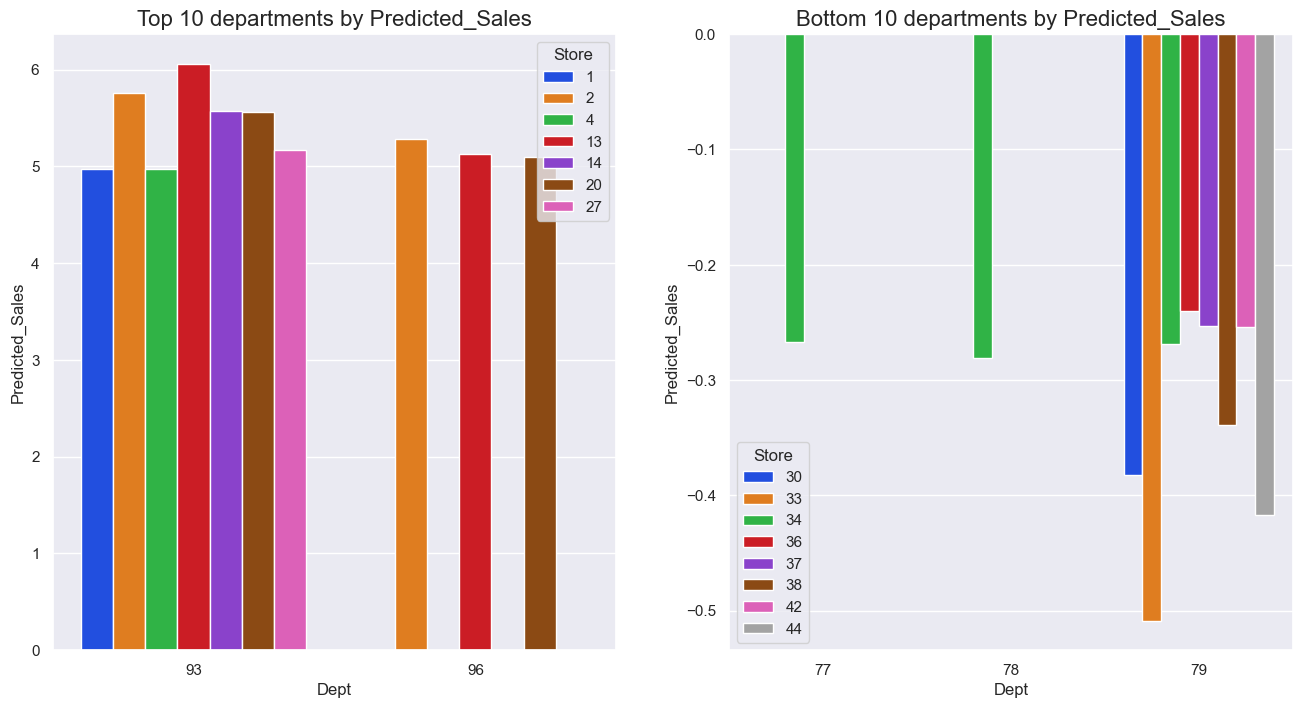

In [156]:
#Top 10 departments by Predicted_Sales Vs Bottom 10 departments by Predicted_Sales
fig, ax = plt.subplots(1,2, figsize= (16,8))

plt.subplot(1,2,1)
sns.barplot(sales_by_dept[:10], x="Dept", y="Predicted_Sales", hue="Store")
plt.title("Top 10 departments by Predicted_Sales", fontsize=16)

plt.subplot(1,2,2)
sns.barplot(sales_by_dept[-10:], x="Dept", y="Predicted_Sales", hue="Store")
plt.title("Bottom 10 departments by Predicted_Sales", fontsize=16)

# fig.tight_layout()

>**Departments 93 & 96 of multiple stores are prospected to achieve the HIGHEST sales for the next year with revenues around 5 million $.**

>**Departments 79, 78 & 77 of multiple stores are prospected to achieve the LOWEST sales for the next year  with losses range from 1/4 to 1/2 million $.**

### 4.2 Store-wise Predicted Sales

In [163]:
#groupby store & dept & sum the predicted sales
sales_by_store = final_X.groupby(["Store"]).agg({"Predicted_Sales":"sum"}).sort_values("Predicted_Sales", ascending=False)
#convert Predicted_Sales to be in Millions $
sales_by_store = sales_by_store.div(1000000, axis=0)
sales_by_store = sales_by_store.reset_index()

In [166]:
sales_by_store

,Store,Predicted_Sales
0,13,83.851160
1,20,81.356440
2,2,78.767272
3,14,78.721312
4,4,74.094920
5,27,70.699872
6,6,70.667400
7,24,69.268808
8,10,69.179224
9,19,66.110212


Text(0.5, 1.0, 'Bottom 5 Stores by Predicted_Sales')

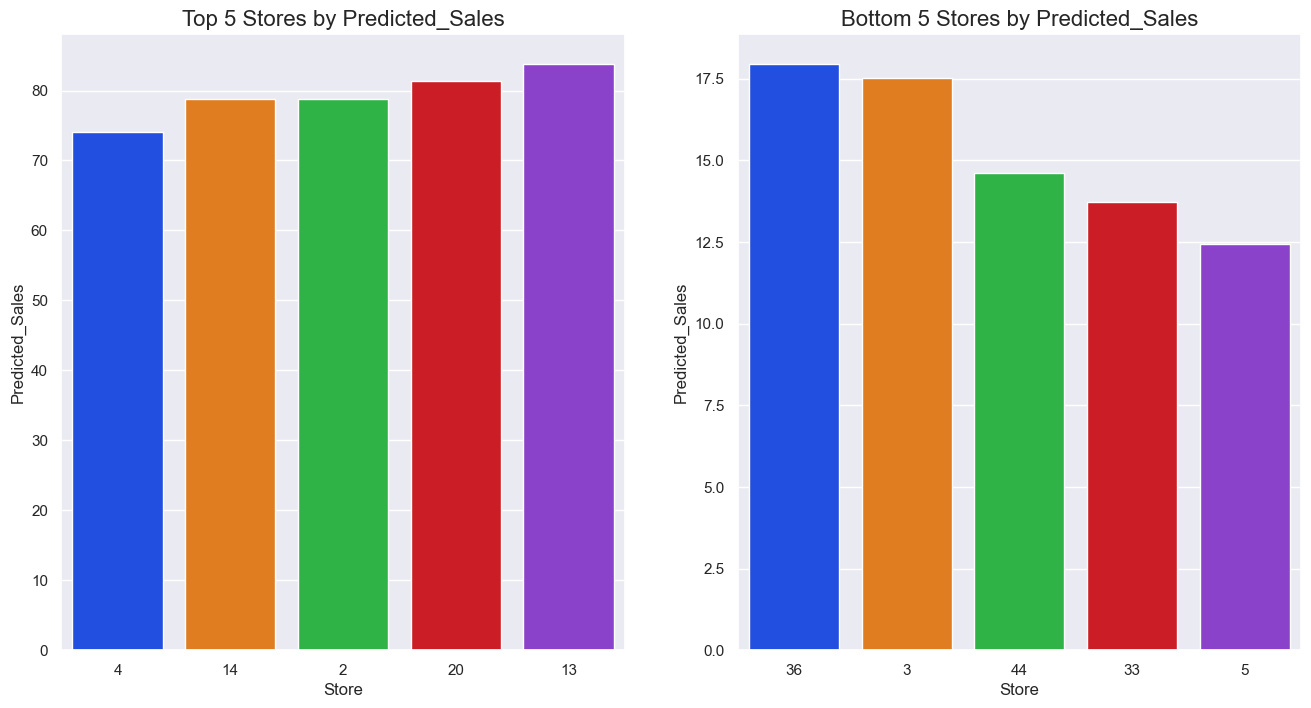

In [186]:
#Top 10 departments by Predicted_Sales Vs Bottom 10 departments by Predicted_Sales
fig, ax = plt.subplots(1,2, figsize= (16,8))

plt.subplot(1,2,1)
sns.barplot(sales_by_store, x="Store", y="Predicted_Sales", 
            order=sales_by_store.sort_values("Predicted_Sales",ascending=True)["Store"][-5:])

plt.title("Top 5 Stores by Predicted_Sales", fontsize=16)

plt.subplot(1,2,2)
sns.barplot(sales_by_store, x="Store", y="Predicted_Sales", 
            order=sales_by_store.sort_values("Predicted_Sales",ascending=False)["Store"][-5:])

plt.title("Bottom 5 Stores by Predicted_Sales", fontsize=16)

# fig.tight_layout()

>**We can see a big gap between the predicted sales for the top 5 that are above 70 million \\$, & the bottom 5 stores that are less than 17.5 million \\$ of the predicted sales .**

## 5. Effect of Markdowns on Sales

<Figure size 1600x800 with 0 Axes>

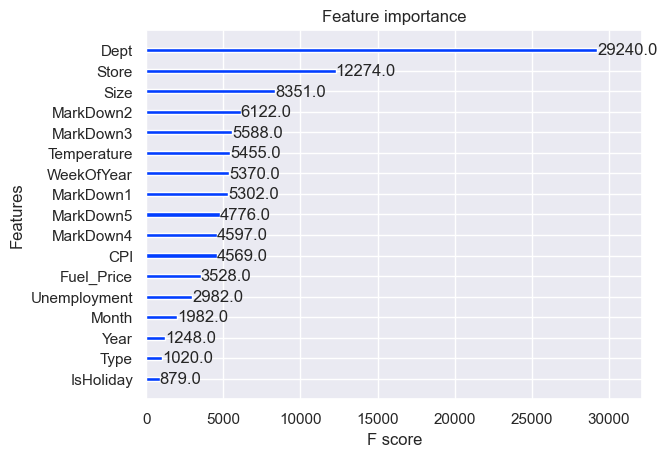

In [190]:
# Plot the feature importance scores
fig = plt.figure(figsize=(16,8))
xgboost.plot_importance(xgb)
plt.show()

>**Markdown2 has the biggest effect on Weekly Sales among other markdowns. This indicates that Markdown2 should be considered more often to draw more sles & revenue.**